In [33]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
import os
import random
import time
import gc
from IPython.display import Markdown, display
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout,SeparableConv2D, Activation, BatchNormalization, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

def printmd(string):   
    display(Markdown(string))
    
np.random.seed(0) # Add random seed of training for reproducibility

def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [32]:
!pip install tensorflow_addons

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.9 MB/s eta 0:00:00m eta 0:00:010:00:010m
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)


In [53]:

images = []
dirp = "train_frames/"
for f in os.listdir(dirp):
    if "jpg" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
            
df = pd.DataFrame(images, columns = ["tag", "frame"])

from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

video_names = sorted(df.tag.unique())
mapper_video_names = dict(zip(video_names, [t for t in range(len(video_names))]))
df["label"] = df["tag"].map(mapper_fruit_names)
print(mapper_video_names)

df

{'Bye ': 0, 'Good ': 1, 'Hello': 2, 'House ': 3, 'Morning': 4, 'Nice ': 5, 'No ': 6, 'Thank You': 7, 'Welcome': 8, 'Work': 9, 'Yes': 10}


,tag,frame,label
0,House,train_frames/House /006_004_001/17.jpg,3
1,Morning,train_frames/Morning/003_010_001/6.jpg,4
2,Morning,train_frames/Morning/003_001_001/12.jpg,4
3,Bye,train_frames/Bye /002_011_001/15.jpg,0
4,Good,train_frames/Good /004_006_001(1)/7.jpg,1
...,...,...,...
7845,Hello,train_frames/Hello/001_010_001/15.jpg,2
7846,Yes,train_frames/Yes/009_014_001/5.jpg,10
7847,Welcome,train_frames/Welcome/008_011_001/20.jpg,8
7848,No,train_frames/No /010_009_001/8.jpg,6


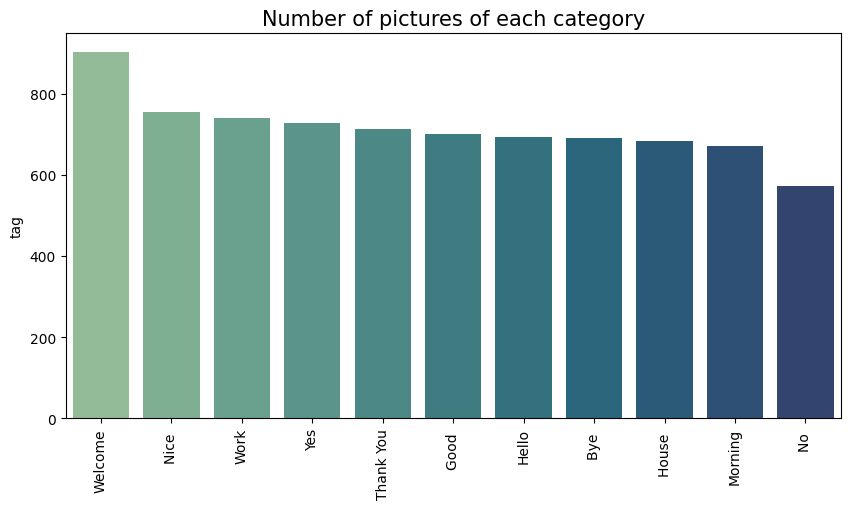

In [57]:
fc = df["tag"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fc.index, y = fc, palette = "crest")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

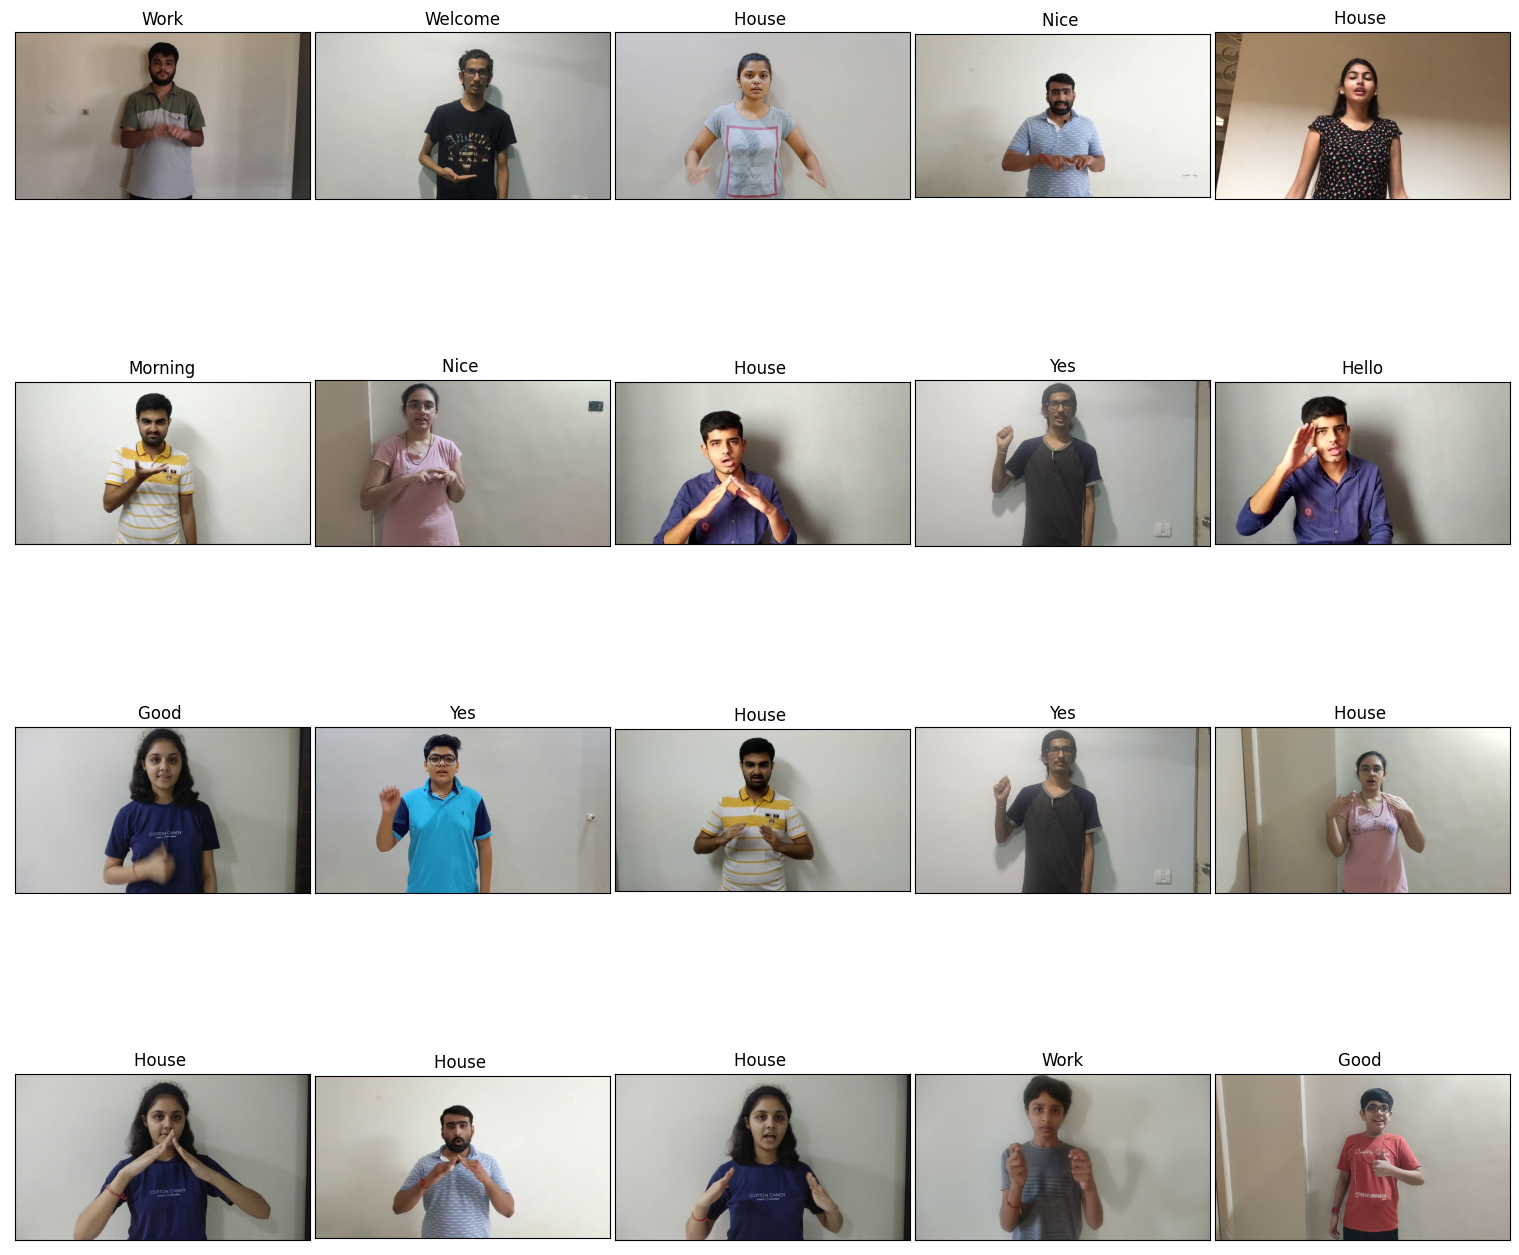

In [38]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i+20]))
    ax.set_title(df.fruit[i+20], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

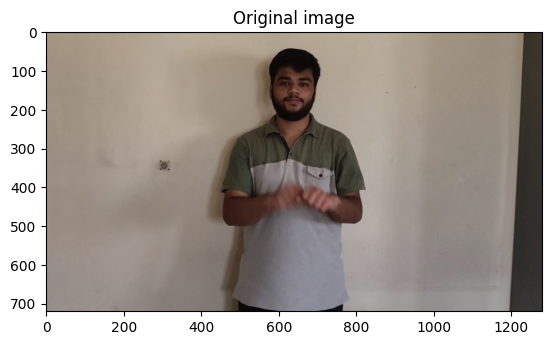

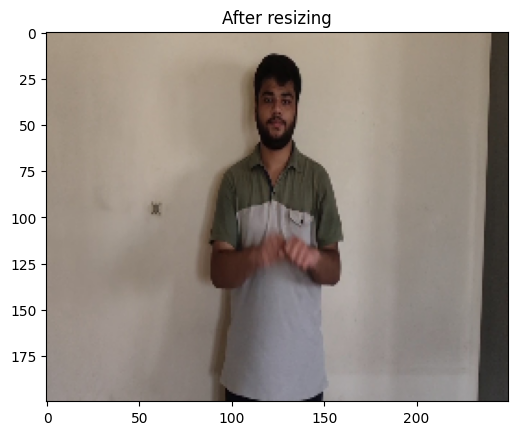

In [41]:
img = plt.imread(df.path[20])
plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (250,200)))
plt.title("After resizing")
plt.show()

In [42]:
def cut_df(df, number_of_parts, part):

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")
        
    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]

def load_img(df):

    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [43]:
def create_model():
    shape_img = (150,150,3)
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(mapper_fruit_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [44]:
def from_categorical(lst):
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

def display_stats(y_test, pred):
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")
    
def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()

In [45]:
model = create_model()
hists = []

divisor = 5

start_time = time.time()
X_train, y_train = load_img(cut_df(df,divisor,1))
y_train = to_categorical(y_train)

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.fit(X_train, y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split = 0.1, verbose = 1)
hists.append(model.history.history)

2023-02-22 01:18:00.815681: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hena/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-22 01:18:00.824783: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-22 01:18:00.824910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hena029): /proc/driver/nvidia/version does not exist
2023-02-22 01:18:00.843069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

Epoch 1/100


2023-02-22 01:18:51.510403: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 368640000 exceeds 10% of free system memory.
2023-02-22 01:18:54.793624: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 368640000 exceeds 10% of free system memory.


 1/12 [=>............................] - ETA: 1:05 - loss: 18.4284 - accuracy: 0.0547

2023-02-22 01:18:55.538759: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 368640000 exceeds 10% of free system memory.
2023-02-22 01:18:57.767534: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 368640000 exceeds 10% of free system memory.


 2/12 [====>.........................] - ETA: 29s - loss: 14.5924 - accuracy: 0.0781 

2023-02-22 01:18:58.477957: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 368640000 exceeds 10% of free system memory.


12/12 [==============================] - 38s 3s/step - loss: 4.9828 - accuracy: 0.0998 - val_loss: 2.4546 - val_accuracy: 0.1019
Epoch 2/100
12/12 [==============================] - 36s 3s/step - loss: 2.4732 - accuracy: 0.1026 - val_loss: 2.4237 - val_accuracy: 0.0701
Epoch 3/100
12/12 [==============================] - 37s 3s/step - loss: 2.4061 - accuracy: 0.1033 - val_loss: 2.4158 - val_accuracy: 0.1019
Epoch 4/100
12/12 [==============================] - 39s 3s/step - loss: 2.4088 - accuracy: 0.1069 - val_loss: 2.4037 - val_accuracy: 0.0828
Epoch 5/100
12/12 [==============================] - 41s 3s/step - loss: 2.3907 - accuracy: 0.1217 - val_loss: 2.4137 - val_accuracy: 0.0637
Epoch 6/100
12/12 [==============================] - 38s 3s/step - loss: 2.3918 - accuracy: 0.1083 - val_loss: 2.4069 - val_accuracy: 0.0446
Epoch 7/100
12/12 [==============================] - 39s 3s/step - loss: 2.3823 - accuracy: 0.1267 - val_loss: 2.3976 - val_accuracy: 0.0637
Epoch 8/100
12/12 [======

Epoch 59/100
12/12 [==============================] - 39s 3s/step - loss: 0.0439 - accuracy: 0.9851 - val_loss: 0.1978 - val_accuracy: 0.9427
Epoch 60/100
12/12 [==============================] - 41s 3s/step - loss: 0.0203 - accuracy: 0.9929 - val_loss: 0.1332 - val_accuracy: 0.9427
Epoch 61/100
12/12 [==============================] - 42s 3s/step - loss: 0.0192 - accuracy: 0.9950 - val_loss: 0.1287 - val_accuracy: 0.9554
Epoch 62/100
12/12 [==============================] - 39s 3s/step - loss: 0.0323 - accuracy: 0.9894 - val_loss: 0.1339 - val_accuracy: 0.9427
Epoch 63/100
12/12 [==============================] - 40s 3s/step - loss: 0.0270 - accuracy: 0.9929 - val_loss: 0.1345 - val_accuracy: 0.9490
Epoch 64/100
12/12 [==============================] - 40s 3s/step - loss: 0.0373 - accuracy: 0.9880 - val_loss: 0.1497 - val_accuracy: 0.9427
Epoch 65/100
12/12 [==============================] - 40s 3s/step - loss: 0.0235 - accuracy: 0.9922 - val_loss: 0.1729 - val_accuracy: 0.9363
Epoch 

In [46]:
gc.collect()

1567

In [47]:
time_model = time.time() - start_time
print(f"Time to train the model: {int(time_model)} seconds")

Time to train the model: 3302 seconds


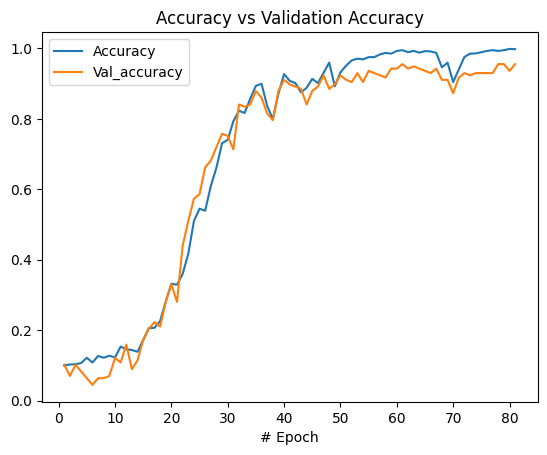

In [48]:
acc = []
val_acc = []
for i in range(len(hists)):
    acc += hists[i]["accuracy"]
    val_acc += hists[i]["val_accuracy"]
hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
plt.title("Accuracy vs Validation Accuracy")
plt.show()

In [49]:
import warnings
warnings.filterwarnings("ignore")

X, y = load_img(cut_df(df, 20, 20))
#pred = model.predict_classes(X)
pred = np.argmax(model.predict(X), axis=1)
y_test = to_categorical(y)

display_stats(y_test, pred)

13/13 [==============================] - 2s 173ms/step
### Result of the predictions using 392 test data ###

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           1       0.85      1.00      0.92        33
           2       1.00      0.93      0.96        27
           3       0.97      1.00      0.99        39
           4       0.97      0.97      0.97        34
           5       1.00      0.94      0.97        33
           6       0.91      0.91      0.91        32
           7       0.98      0.98      0.98        47
           8       0.98      0.96      0.97        48
           9       1.00      0.97      0.98        32
          10       0.97      1.00      0.99        35

    accuracy                           0.96       392
   macro avg       0.97      0.96      0.96       392
weighted avg       0.97      0.96      0.96       392


Confusion Matrix:


[[30  0  0  0  0  0  1  0  1  0 

# Accuracy: 0.96429

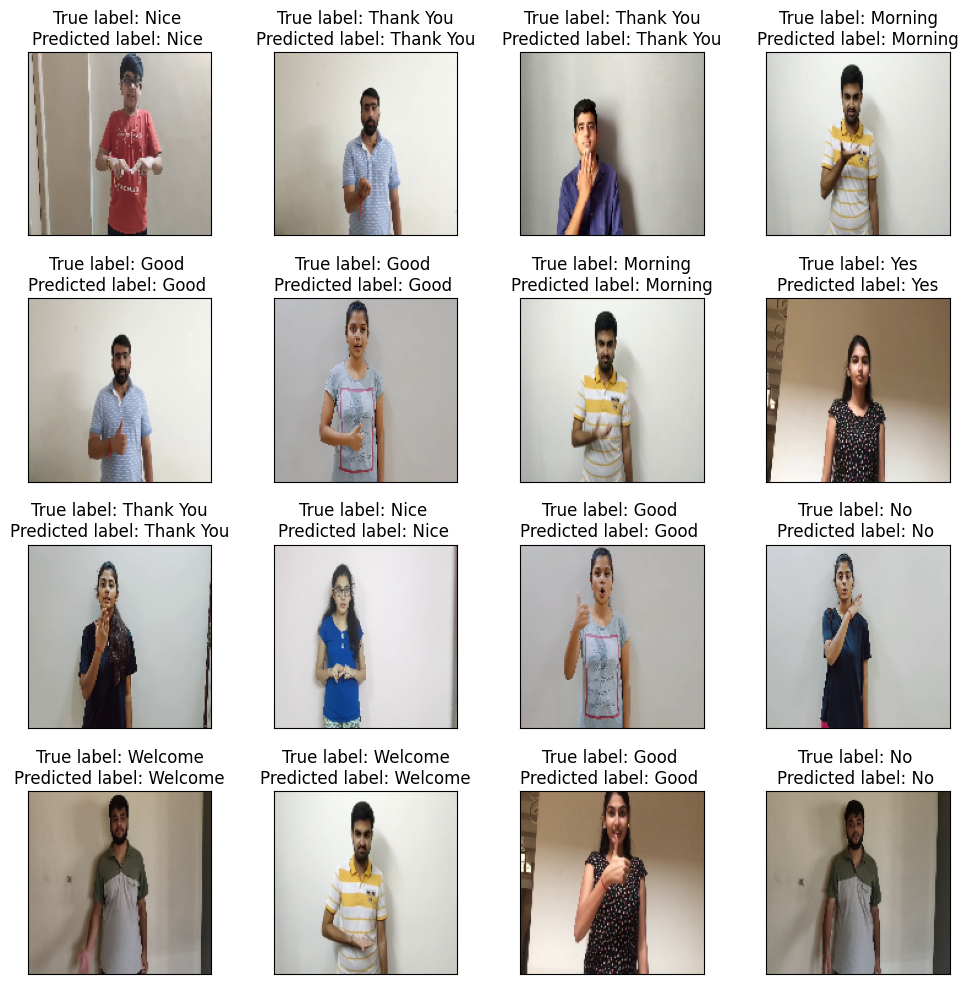

In [50]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X[-i])
    ax.set_title(f"True label: {fruit_names[y[-i]]}\nPredicted label: {fruit_names[pred[-i]]}")

plt.tight_layout()
plt.show()